# This notebook corresponds to the Kaggle CNN Activity


In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras as ke
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

#importing NMIST data
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
#splitting into train/validation data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

### Showing some exploratory data plots

/opt/anaconda3/envs/VAIL_AI_CODE/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


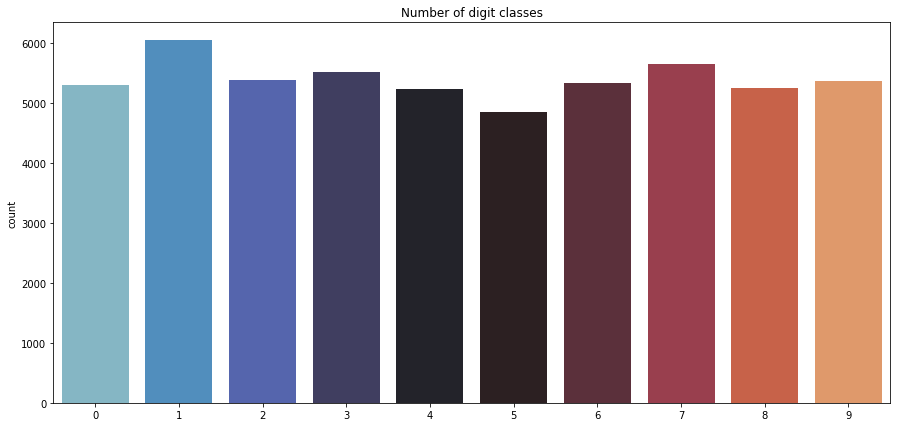

In [2]:
#Digit Distrbutions
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
plt.show()

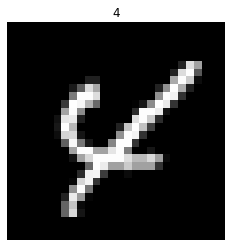

In [3]:
#example image from x_train/ Dataset

#pulling 0th x image array from x_train
x_img_arr = X_train[0,:]
#configuring plot
plt.imshow(x_img_arr,cmap='gray')
#titling w/ the image's respective #
plt.title(f'{Y_train[0]}')
plt.axis("off")
plt.show()

### As per the kaggle notebook, we must normalize+reshape+label encode data for easier model training

#### Similar taking a z score in stats, this division by 255 will normalize our data and squish pixel values to be bound from 0-->1
#### Pixel values in x arrays can only range from 0 --> 255, therefore dividing x arrays through by 255 will make nice data

In [4]:
#dividing through by 255
X_train = X_train/255.0
X_test = X_test/255.0

In [5]:
#reshaping x data so it is of the form (# of images,image width,image height,ColorDimension)
"""
Note:
ColorDimension = the # of data components associated with the pixels which give rise to our image.
RGB images have a CD of 3 (each pixel contains data for Red,Green,Blue)
By Contrast, Grayscale images have a CD of 1 (each pixel only contains data for its degree of black)
"""
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

#### label encoding = converting non numeric data labels (such as tall/short) to numbers (such as 1/0)
#### label encoding is critical because it allows our model to calculate loss duing Supervised Learning and perform GD
#### in this case, y labels will be encoded w.r.t to the number they represent
#### ex: if the y output number is 7, we will label encode such that the model recieves a y output vector:

[[0],[0],[0],[0],[0],[0],[0],[1],[0],[0]]

#### For each feed forward, we will compare the ith neuron's prediction vs. the ith position in our label encoded y array
#### Very easy to directly calcualte associated log losses from each neuron in the output layer and backpropogate


In [6]:
#label encoding y train & test data
Y_train = to_categorical(Y_train, num_classes = 10)
#Y_train = Y_train.reshape(Y_train.shape[0],1,Y_train.shape[1])
Y_test = to_categorical(Y_test, num_classes = 10)
#Y_test = Y_test.reshape(Y_test.shape[0],1,Y_test.shape[1])

#### Data has now been standardized, reshpaed, & label encoded. Now we can import CNN models for fitting


In [7]:
#making model imports from keras

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

#### Our Cnn will have 2 Conv layers, 2 Pool Layers. We will then flatten data & Feed into Fully Connected NN wtih layers (1 input, 1 output)
#### We will perform 2 droupouts during forward propogation to combat overfitting

##### conv --> pool --> [dropout regularization] conv --> pool --> [dropout regularization] Flatten Data --> Fully Connnected ANN

In [8]:
#importing general model
model = Sequential()
#conv layer 1
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
#pooling layer 1
model.add(MaxPool2D(pool_size=(2,2)))
#first dropout regularization
model.add(Dropout(0.25))
#conv layer 2
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
#pooling layer 2
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#second dropout regularization
model.add(Dropout(0.25))

#flattening model tensors before feeding into FC NN
model.add(Flatten())

#we have 256 Neurons b/c we have flattend our pooled data matrix to be of length 256 (we need 1 neruon per input variable)
model.add(Dense(256, activation = "relu"))
#third dropout regularization
model.add(Dropout(0.5))
#output layer w/ 10 neurons to perform the digit classification
model.add(Dense(10, activation = "softmax")) #emply softmax b/c mulitonomial classification [0-->9]


In [9]:
#defining the GD optimizer for our model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#defining our multinomial cost function
model.compile(optimizer = optimizer , loss='categorical_crossentropy', metrics=["accuracy"])

In [10]:
#defining epoch # and batch size
epochs = 20
batch_size = 250 #input data is 54k so we will have 216 batches each epoch

In [11]:
#as another stall against overfitting we will inject some noise into our images
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

datagen.fit(X_train)

In [12]:
#fitting our model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/20
216/216 [==============================] - 39s 171ms/step - loss: 1.4068 - accuracy: 0.5247 - val_loss: 0.1642 - val_accuracy: 0.9515

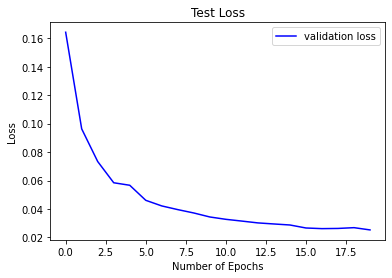

In [13]:
#plotting model test accuracy vs iteration
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

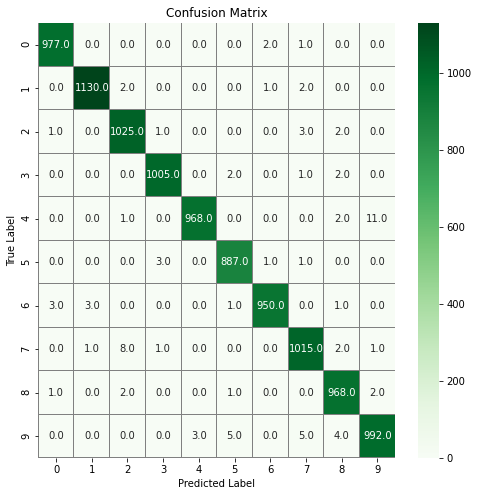

In [14]:
#pulling up a confusion matrix to get a richer understanding of model's predictions
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### As Shown by the straight diagonal down our Confusion Matrix, our CNN Model has both high specificity and high general accuracy (99.17%)

